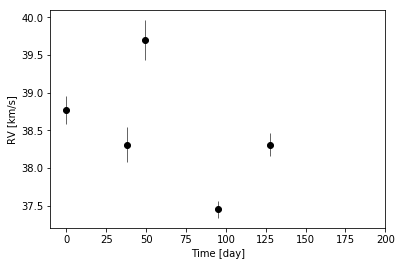

In [20]:
""" This is the tutorial in how to use the Joker taken from the documentation page. """
from thejoker.data import RVData
from thejoker.plot import plot_rv_curves
from thejoker.sampler import compute_likelihoods
import astropy.units as  u
import matplotlib.pyplot as plt
import numpy as np
import schwimmbad
t = [0., 49.452, 95.393, 127.587, 38.31]
rv_dat = [38.77, 39.70, 37.45, 38.31, 38.31]* u.km/u.s
err = [0.184, 0.261, 0.112, 0.155, 0.233] * u.km/u.s

#t = [0.0, 2.9883000003173947, 27.93244000012055, 30.923119999933988, 35.92739999992773, 
#     63.85682999994606, 66.85045000026003]
#rv =[25.313385, 25.192486, 25.721413, 25.3508, 25.458048, 25.524765, 25.467243] * u.km/u.s
#err = [0.026613813, 0.04872429, 0.029271094, 0.026994251, 0.033509318] * u
data = RVData(t = t, rv=rv_dat, stddev = err)
ax = data.plot()
ax.set_xlim(-10,200)
ax.set_xlabel("Time [day]")
ax.set_ylabel("RV [km/s]")
plt.show(ax)

In [63]:
t

[0.0, 38.31, 49.452, 95.393, 127.587]

INFO: 43 good samples after rejection sampling [thejoker.sampler.sampler]


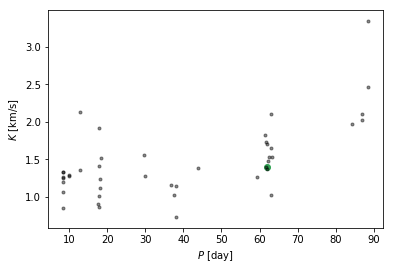

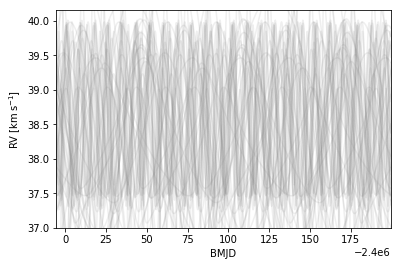

In [21]:
from thejoker.sampler import TheJoker
joker = TheJoker(params)
samples = joker.rejection_sample(data, n_prior_samples = 65036)
name_thing = 'name thing?'
fig, ax = plt.subplots(1,1)
ax.scatter(samples['P'].value, samples['K'].to(u.km/u.s).value,
           marker='.', color= 'k',alpha=0.45)
ax.set_xlabel('$P$ [day]')
ax.set_ylabel('$K$ [km/s]')
#ax.set_xlim(-5,128)
#ax.set_ylim(0.75, 3.)

ax.scatter(61.942, 1.3959, marker='o', color='#31a354', zorder=-100)

fig, ax = plt.subplots(1,1)
t_grid = np.linspace(-5,200,1024)
plot_rv_curves(samples, t_grid, rv_unit =u.km/u.s, data = data, ax=ax,
              plot_kwargs=dict(color='#888888'),relative_to_t0=True)
#ax.set_xlim(-5,100)
#ax.set_ylim(25.1,26.8)
plt.show()

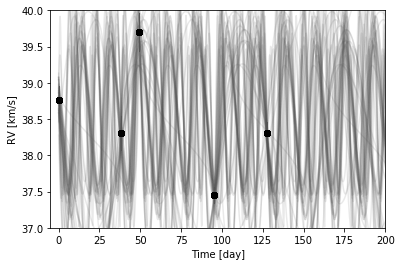

In [16]:
#This Is going through and doing all the things that plot_rv_curves does, but by doing this I can get back the 
#pridicted analytical radial velocities
import astropy.units as u
import numpy as np

from astropy.time import Time
from twobody import KeplerOrbit
from astropy.time import Time

from astropy.table import Table
from twobody.wrap import cy_rv_from_elements
from twobody.utils import ArrayProcessor

#Loop through all the different good samples that survive rejection. 
ln_L = np.zeros(len(samples))
for n in range(len(samples)):
    
    #For each of the samples read in their respective orbital paramiters. I haven't read in jitter becasue in all of
    #my cases I've set the jitter to be zero
    P = samples['P'][n]
    e = samples['e'][n]
    M0 = samples['M0'][n]
    omega = samples['omega'][n]
    K = samples['K'][n]
    v0 = samples['v0'][n]
    s = samples
    t_foo = np.linspace(t[0], 200,1024) #make a lin space for the radial velocity plot. 
   
    t_foo = Time(t_foo, format = 'mjd')
    t_dat = Time(t, format = 'mjd')

    t_foo = t_foo.tcb.mjd
    t_dat = t_dat.tcb.mjd

    proc = ArrayProcessor(t_foo)
    proc2 = ArrayProcessor(t_dat)

    t_foo, = proc.prepare_arrays()
    t_dat, = proc2.prepare_arrays()

    t0  = t_foo[0]
    td0 = t_dat[0]

    t0  = Time(t0 , format = 'mjd')
    td0 = Time(td0, format = 'mjd')
    
    rv = cy_rv_from_elements(t_foo, P.to(u.day).value, 1., e, omega.to(u.radian).value,
                             M0.to(u.radian).value, t0.tcb.mjd, 
                             anomaly_tol = 1E-10, anomaly_maxiter = 128)
    
    rv_an = cy_rv_from_elements(t_dat, P.to(u.day).value, 1., e, omega.value,
                             M0.value, td0.tcb.mjd, 
                             anomaly_tol = 1E-10, anomaly_maxiter = 128)
    rv = K*rv + v0
    
    #rv_an is the analytical radial velocity evaluated at the times that we made the actual observations
    rv_an = K*rv_an + v0

    plt.plot(t_foo,rv,color='#555555' ,linestyle = '-', marker = '', alpha = 0.05 + 4./(len(samples) + 4.), rasterized = True)
    
    data = RVData(t = t, rv=rv_dat, stddev = err)
    ax = data.plot()
    ax.set_xlim(-5,200)
    ax.set_xlabel("Time [day]")
    ax.set_ylabel("RV [km/s]")
ax.set_xlim(-5,200)
ax.set_ylim(37,40)
plt.show(ax) 
    #Now that I have an 'analytic' radial velocity i want to find the ln_likelihood
diff = (rv_dat - rv_an)**2
chi_2 = diff /((err)**2) 
thing_2b_summed = chi_2 + np.log(2*np.pi*(err.value**2))
ln_L[n] = -0.5*sum(thing_2b_summed)

In [267]:
ln_L

array([ 0.86809449, -1.22810527, -0.39878652,  2.899874  ,  2.58974867,
        1.20636528,  1.93175371,  2.50093029,  1.0849167 ,  1.01887618,
        1.72979683, -0.65829772,  1.61777033,  0.44034385,  2.03112023,
        3.68398156,  0.85066002,  2.23500806, -7.05477974, -8.31197931,
        1.92882926,  2.76661596,  2.08955868,  2.67972534,  2.69797872,
        1.60607855,  0.46842718,  2.9250938 ,  1.00535593, -1.23937769,
       -2.08386262,  2.1280161 , -1.24138963,  2.71314292,  2.70229833,
        1.93761543,  1.55352211, -3.34662774, -1.3715275 ,  0.43309062,
        0.96105414,  2.79111128, -0.29761167,  1.21499399, -1.31114468])

In [270]:
diff = (rv_dat - rv_an)**2
chi_2 = diff /((err)**2) 
foo = chi_2 + np.log(2*np.pi*(err.value**2))


In [271]:
diff

<Quantity [0.00453562, 0.29655381, 0.00319469, 0.00230168, 0.30878664] km2 / s2>

In [272]:
chi_2

<Quantity [0.13396803, 4.35333909, 0.25467843, 0.0958034 , 5.68783066]>

In [273]:
np.log(2*np.pi*(err.value**2))

array([-1.54776198, -0.84859268, -2.54063575, -1.89078326, -1.07555658])